# Gaussian Process Classification step 5-7

### Methods
The Gaussian Process Classifier (GPC) is a probabilistic, non-parametric machine learning method. It is particularly well-suited for classification tasks where the decision boundaries are complex and not easily defined by simple linear models. GPC models the data distribution using a Gaussian process, which allows it to capture non-linear relationships in the data.

In these steps, we will look at scaling the data, choosing subsets of the dataset to train on and we will outline different kernels to try

### Workflow
- Gaussian Process Classifier:

    We will create an instance of the Gaussian Process Classifier with an RBF kernel and train it on the preprocessed data.

    We will define different kernels to try step 7 and see which kernel performs best on our downscaled data, in the context of computational effiency. The best performing kernel will then be chosen and upscaled.


In [1]:
%%capture
!pip install cartopy
!pip install gpflow

In [2]:
import sys
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import resample
sys.path.append("/Users/Lisanne/Documents/AI4ER/PhD/GPs")

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import gpflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import accuracy_score, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mean_df = pd.read_pickle("/content/drive/MyDrive/ai4er/GPs/data/processed/ml_ready/coldwarmclass.pkl")

## Data preparation: recap from 1-4

In [5]:
merged_df = mean_df

# Count the occurrences of each class in the "WaterMass" column
class_counts = merged_df["WaterMass"].value_counts()

# Find the count of the third class
desired_class_count = class_counts[3]

# Create an empty DataFrame to store the balanced data
balanced_df = pd.DataFrame()

# Iterate over unique classes and balance the samples based on the count of the third class
for unique_class in merged_df["WaterMass"].unique():
    class_data = merged_df[merged_df["WaterMass"] == unique_class]
    class_balanced = resample(class_data, n_samples=desired_class_count, random_state=42)
    balanced_df = pd.concat([balanced_df, class_balanced])

In [6]:
len(balanced_df)

3836

In [8]:
ref_latitude = 50
ref_longitude = -100

# Function to calculate angle between two points and the reference point
def calculate_angle(lat, lon):
  lat_rad, lon_rad = map(math.radians, [lat, lon])
  ref_lat_rad, ref_lon_rad = map(math.radians, [ref_latitude, ref_longitude])

  delta_lon = lon_rad - ref_lon_rad

  y = math.sin(delta_lon) * math.cos(lat_rad)
  x = math.cos(ref_lat_rad) * math.sin(lat_rad) - (math.sin(ref_lat_rad) * math.cos(lat_rad) * math.cos(delta_lon))

  angle_rad = math.atan2(y, x)
  angle_deg = math.degrees(angle_rad)
  return angle_deg

# Calculate angle for each point in the DataFrame
balanced_df['bearing'] = balanced_df.apply(lambda row: calculate_angle(row['latitude'], row['longitude']), axis=1)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Calculate distances from each point to the reference point
balanced_df['distance'] = haversine(ref_latitude, ref_longitude, balanced_df['latitude'], balanced_df['longitude'])

# Assuming 'balanced_df' already contains a 'month' column
balanced_df['seasonal_sin'] = np.sin(2 * np.pi * balanced_df['month'] / 12)

## Define training and test dataset

In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

n_clusters_per_region = 80

# Use KMeans for clustering within each region
kmeans_clusters = KMeans(n_clusters=n_clusters_per_region, n_init=n_clusters_per_region, random_state=7)
balanced_df['cluster'] = kmeans_clusters.fit_predict(balanced_df[['latitude', 'longitude']])

# Determine which clusters to assign to train, val, and test
cluster_indices = balanced_df['cluster'].unique()

# Assuming 'cluster' is the column containing cluster labels in balanced_df
clusters = balanced_df['cluster'].unique()

# Split clusters into training and validation sets
train_clusters, split_clusters = train_test_split(clusters, test_size=0.3, random_state=42)
val_clusters, test_clusters = train_test_split(split_clusters, test_size=0.4, random_state=42)

# Create training and validation datasets
train_dataset = balanced_df[balanced_df['cluster'].isin(train_clusters)]
val_dataset = balanced_df[balanced_df['cluster'].isin(val_clusters)]
test_dataset = balanced_df[balanced_df['cluster'].isin(test_clusters)]

# Verify the size of each dataset
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))

Train Dataset Size: 2914
Test Dataset Size: 922


# Step 5: Scaling structures
Sparse GP regression with inducing points, think spatially

In [ ]:
from sklearn.cluster import KMeans

# Use k-means to obtain inducing points, randomly but with spatial variation
num_classes = 4
num_inducing_points = 100
kmeans = KMeans(n_clusters=num_inducing_points, random_state=42)
kmeans.fit(train_dataset['distance', 'bearing', 'depth', 'seasonal_sin'])

inducing_points = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Step 6: Data transformations
GPs are non-parametric models that make assumptions about the distribution of the data. While they don't assume a specific functional form for the distribution, they do assume smoothness and continuity.

If your features have a non-Gaussian distribution, it may be worthwhile to visualize their distributions. If transformations like logarithmic or Box-Cox transformations can make the features more Gaussian-like, it might be worth considering.

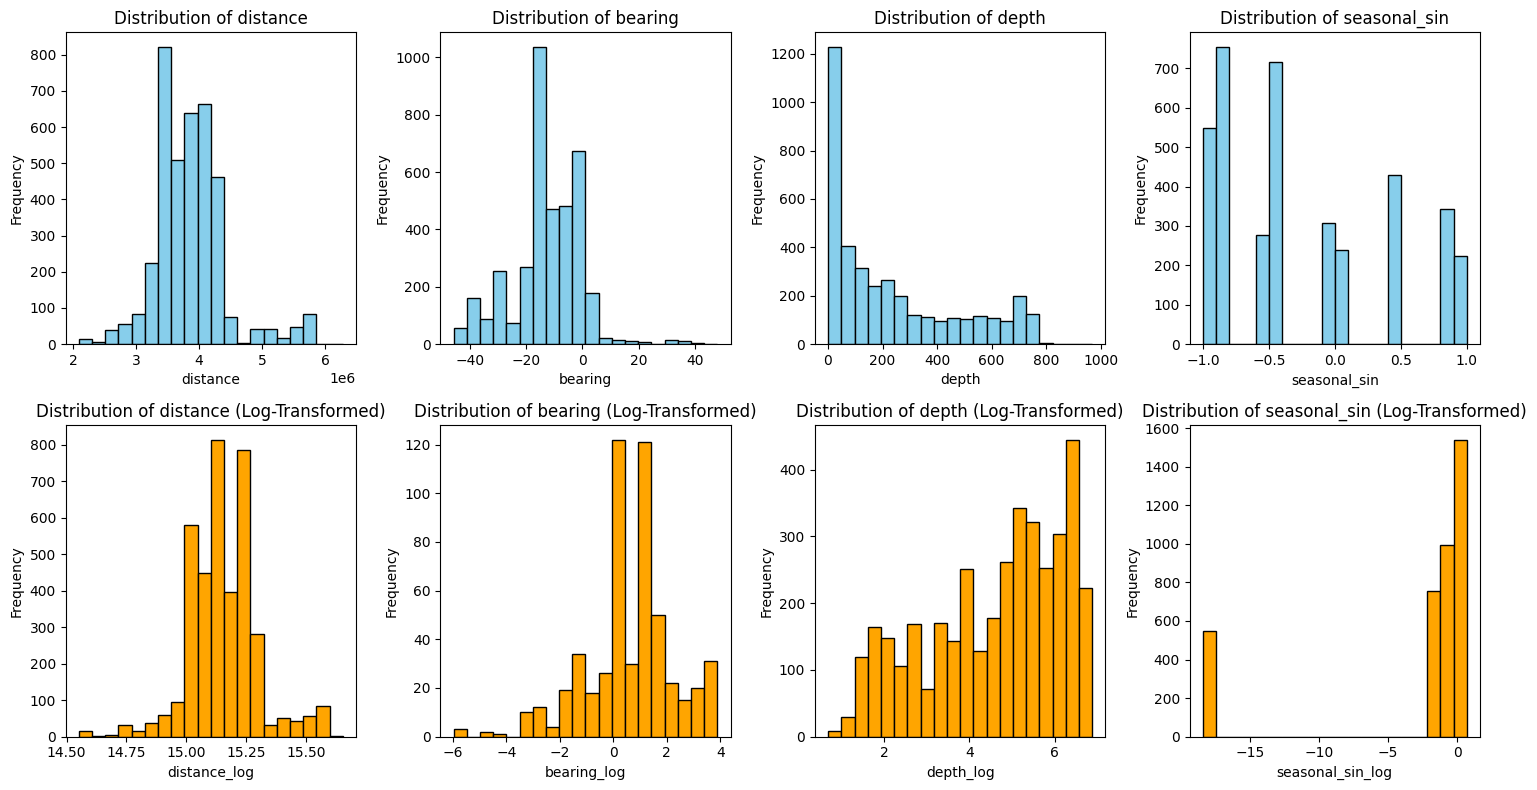

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# List of feature names
feature_names = ['distance', 'bearing', 'depth', 'seasonal_sin']

# Apply log1p transformation to all features
for feature in feature_names:
    if (balanced_df[feature] <= 0).any():
        print(f"Warning: '{feature}' contains zero or negative values. Applying log1p transformation.")
        balanced_df[f'{feature}_log'] = np.log1p(balanced_df[feature] + 1e-8)
    else:
        balanced_df[f'{feature}_log'] = np.log1p(balanced_df[feature])

# Plot histograms for original and log-transformed features
plt.figure(figsize=(15, 8))

for i, feature in enumerate(feature_names, 1):
    plt.subplot(2, len(feature_names), i)
    plt.hist(balanced_df[feature], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.subplot(2, len(feature_names), i + len(feature_names))
    plt.hist(balanced_df[f'{feature}_log'], bins=20, color='orange', edgecolor='black')
    plt.title(f'Distribution of {feature} (Log-Transformed)')
    plt.xlabel(f'{feature}_log')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In this case, it is a good idea to Z-scale the variables, looking at the mean and standard deviation. Sklearn StandardScaler is an easy way of implemeting that.

In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf

# List of feature names
feature_names = ['distance', 'bearing', 'depth', 'seasonal_sin']

# Extract features and target variable from train_dataset
X_train_dataset = train_dataset[feature_names]
y_train_dataset = train_dataset['WaterMass']

# Extract features and target variable from val_dataset
X_val_dataset = val_dataset[feature_names]
y_val_dataset = val_dataset['WaterMass']

# Extract features and target variable from test_dataset
X_test_dataset = test_dataset[feature_names]
y_test_dataset = test_dataset['WaterMass']

# Encode categorical labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded_dataset = label_encoder.fit_transform(y_train_dataset).reshape(-1, 1)
y_val_encoded_dataset = label_encoder.transform(y_val_dataset).reshape(-1, 1)
y_test_encoded_dataset = label_encoder.transform(y_test_dataset).reshape(-1, 1)

# Reshape without creating an additional dimension
y_train_encoded_dataset = y_train_encoded_dataset.reshape(-1)
y_val_encoded_dataset = y_val_encoded_dataset.reshape(-1)
y_test_encoded_dataset = y_test_encoded_dataset.reshape(-1)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled_dataset = scaler.fit_transform(X_train_dataset)
X_val_scaled_dataset = scaler.transform(X_val_dataset)
X_test_scaled_dataset = scaler.transform(X_test_dataset)

Can consider using depth_log as a feature and potentially r_log.

However, in this scenario, most features are spatial and therefore the distribution would stay relevant of the features.

# Step 7: Kernel Design

In this step, we will explore three different kernels with increasing complexity to find the most suitable kernel for our Gaussian Process classification model.

## 1. RBF Kernel with Lengthscale 1 for All Features (Baseline)

The first kernel serves as a baseline and uses the Radial Basis Function (RBF) kernel with a fixed lengthscale of 1 for all features. This choice provides a simple starting point for evaluating the model's performance.

## 2. Matern Kernel with Lengthscale 1

The second kernel introduces the Matern kernel with a lengthscale of 1. The Matern kernel offers adaptability with its parameter 𝜈, allowing us to control the smoothness of decision boundaries. A lengthscale of 1 provides a moderate level of sensitivity to variations.

## 3. RBF Kernel with Different Lengthscales for Each Feature

For the third kernel, we customize the RBF kernel by assigning different lengthscales to each feature:
- For distance, representing the distance from the reference point, a scale of 1 is assumed.
- For 𝜃, dictating the angle from the reference point, a smaller scale of 0.1 is assumed.
- For depth, with a large range, a scale of 1 is assumed.
- For seasonal_sin, assuming less variation, a scale of 0.1 is assumed.

This customization allows the model to adapt to the varying scales and patterns present in different features.

## 4. RBF Kernel with Seasonal Component and White Noise

The fourth and final kernel is a combination of an RBF kernel with a seasonal component related to the time feature. This seasonal component is then summed up with a white noise kernel, accounting for noise in observational data and the labeling process. This kernel design aims to capture both periodic patterns and potential noise in the data.

In summary, by systematically exploring these kernels, we aim to identify the most effective kernel for our Gaussian Process classification model, considering the unique characteristics of each feature and the complexity required for accurate classification.
